In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("train.csv")
df.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


In [3]:
df.shape

(19237, 18)

# Preprocessing

In [4]:
df.drop_duplicates(inplace=True)
df.shape

(18924, 18)

In [5]:
df2 = df[df["Price"]<50000]
df2.reset_index(inplace = True, drop = True)
df2.shape

(18016, 18)

## Cleaning Engine Volume

In [6]:
def Eng_Vol2(df3):
    turbo = []
    Engine_Volume = []
    for vol in df3["Engine volume"]:
        if len(vol)>4:
            turbo.append(1)
            vol = vol[0:3]
            Engine_Volume.append(float(vol))
        else:
            turbo.append(0)
            Engine_Volume.append(float(vol))
            
    df3.drop(columns = "Engine volume", inplace = True)
    df3["Engine volume"] = Engine_Volume
    df3["Turbo"] = turbo
    return df3 

## Cleaning Mileage

In [7]:
def mileage(df3):
    mile = []
    for mil in df3["Mileage"]:
        mil = mil[0:-3]
        mile.append(int(mil))

    df3.drop(columns = "Mileage", inplace = True)
    df3["Mileage"] = mile
    return df3

## Dropping ID and Cleaning Levy 

In [8]:
def drop_ID_n_clean_levy(df3):
    df3.drop(columns = "ID", inplace = True)
    df3["Levy"].replace(to_replace='-', value = np.nan, inplace = True)
    df3["Levy"] = pd.to_numeric(df3["Levy"])
    Levy_median = df3["Levy"].median()
    df3["Levy"].fillna(Levy_median, inplace = True )
    return df3, Levy_median

In [9]:
df2 = Eng_Vol2(df2)
df2 = mileage(df2)
df2, Levy_median = drop_ID_n_clean_levy(df2)
df2.describe()


C:\Ana\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-6-fbbcc2efe004>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3["Engine volume"] = Engine_Volume
<ipython-input-6-fbbcc2efe004>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3["Tu

,Price,Levy,Prod. year,Cylinders,Airbags,Engine volume,Turbo,Mileage
count,18016.000000,18016.000000,18016.000000,18016.000000,18016.000000,18016.000000,18016.000000,1.801600e+04
mean,14322.872003,859.321214,2010.695215,4.544738,6.564887,2.277825,0.092362,1.629709e+06
std,11758.530068,390.710590,5.615763,1.157580,4.320148,0.856101,0.289545,5.001581e+07
min,1.000000,87.000000,1939.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,4861.000000,707.000000,2009.000000,4.000000,4.000000,1.800000,0.000000,7.400000e+04
50%,12500.000000,779.000000,2012.000000,4.000000,6.000000,2.000000,0.000000,1.299945e+05
75%,20385.000000,891.000000,2014.000000,4.000000,12.000000,2.500000,0.000000,1.905490e+05
max,49889.000000,11714.000000,2020.000000,16.000000,16.000000,20.000000,1.000000,2.147484e+09


## Target Encoding

In [10]:
def target_encoding(df3, categ_var):
    df4=df3
    enc_dict = {}
    for var in categ_var:
        encodings = df4.groupby(var)['Price'].median().reset_index()
        df4 = df4.merge(encodings, how='left', on=var)
        df4.drop(var, axis=1, inplace=True)
        df4.rename(columns = {"Price_y": var + "_enc", "Price_x": "Price"}, inplace = True) 
        enc_dict[var] = encodings
    return df4, enc_dict

In [11]:
def OneHot_encoding(df3, categ):
    
    df4 = df3
    dummy = pd.get_dummies(df4[categ])
    #df4 = df4.drop(columns = categ, axis=1)
    df4=pd.concat((df4,dummy),axis=1)
        
    return df4

## Handling Leather interior

In [12]:
#For Leather Interiors
def LI(df4):
    df4["Leather interior"].replace({"Yes":1, "No":0}, inplace = True)
    return df4

C:\Ana\lib\site-packages\pandas\core\series.py:4509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


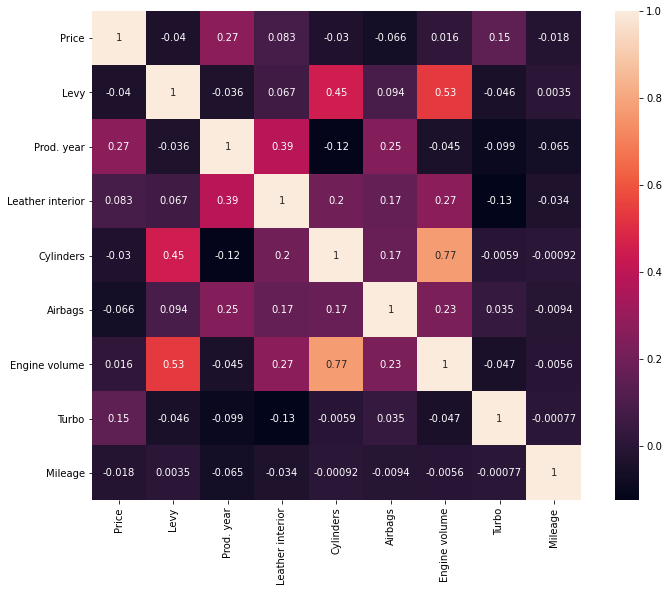

In [13]:
df3 = LI(df2)

corrmat = df3.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=1, square=True, annot = True);

In [14]:
categ_variables = ["Model", "Color", "Manufacturer", "Category", "Fuel type", "Gear box type", "Drive wheels", "Doors","Wheel"]
one_hot_categ = ["Category", "Fuel type", "Gear box type", "Drive wheels", "Doors", "Wheel"]
target_categ = ["Model","Color","Manufacturer"]


In [15]:
#########################
df3 = df2


In [16]:
#################################################
#df4 = OneHot_encoding(df2, one_hot_categ)
df4, tar_enc_dict = target_encoding(df3, categ_variables)
df4 = LI(df4)

<AxesSubplot:>

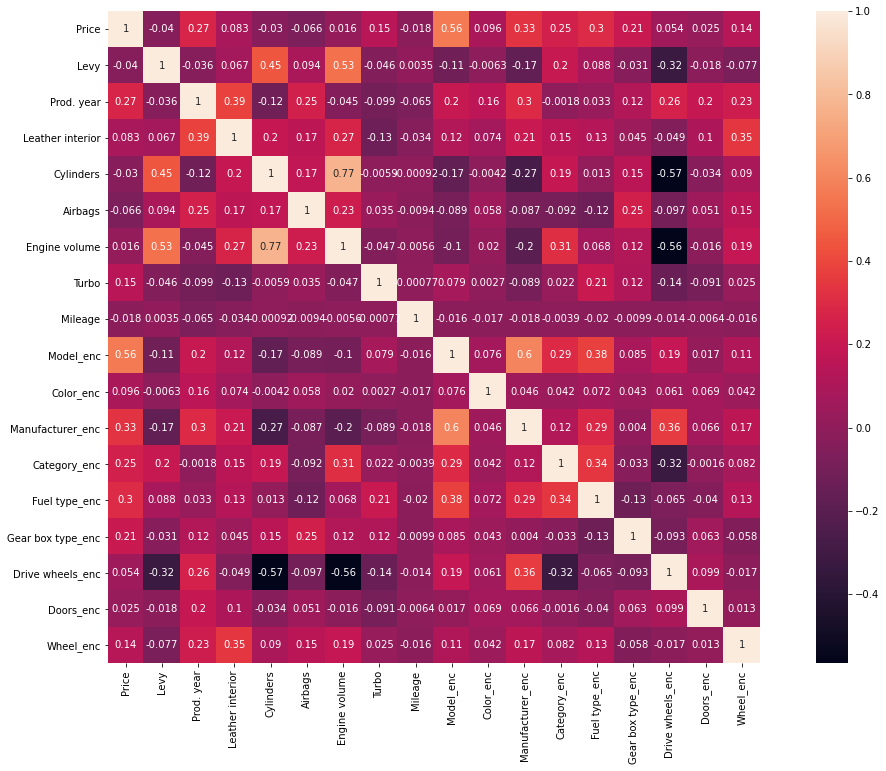

In [17]:
plt.figure(figsize =  (20,12))
sns.heatmap(df4.corr(), square = True, annot = True)

## Fixing Levy

In [18]:
# Fixing Levy
#df2 = df2[df2["Levy"]<6000]
#df2 = df2[df2["Levy"]>250]

levy = []
levy_max = df4.Levy.mean() + (3* df4.Levy.std())
levy_min = df4.Levy.mean() - (2* df4.Levy.std())
for l in df4["Levy"]:
    if l>2000:
        levy.append(levy_max)
    elif(l<77):
        levy.append(levy_min)
    else:
        levy.append(l)
        
df4.drop(columns = "Levy", inplace = True)
df4["Levy"] = levy
df4.shape

(18016, 18)

### Levy correction worked

# Airbag Correction worked

<AxesSubplot:xlabel='Airbags', ylabel='Price'>

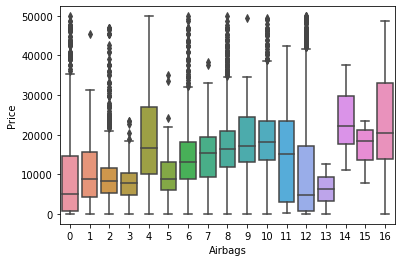

In [19]:
sns.boxplot(x = df4["Airbags"], y = df4["Price"])

In [20]:
##########################
i1 = df4[((df4["Airbags"]==0) & (df4["Price"]>40000)) | ((df4["Airbags"]==1) & (df4["Price"]>40000)) | ((df4["Airbags"]==2) & (df4["Price"]>29000))].index
i2 = df4[((df4["Airbags"]==5) & (df4["Price"]>28000)) | ((df4["Airbags"]==6) & (df4["Price"]>36000)) | ((df4["Airbags"]==7) & (df4["Price"]>35000))].index
i3 = df4[((df4["Airbags"]==8) | (df4["Airbags"]==9) | (df4["Airbags"]==10)) & (df4["Price"]>40000)].index

In [21]:
#############################
i4 = df4[((df4["Airbags"]==16) & (df4["Price"]>44000))].index
t_df = df4.drop(index = i1)
t_df = t_df.drop(index = i2)
t_df = t_df.drop(index = i3)
t_df = t_df.drop(index = i4)
t_df.shape

(17797, 18)

In [22]:
##########################################
df4 = t_df

<AxesSubplot:xlabel='Airbags', ylabel='Price'>

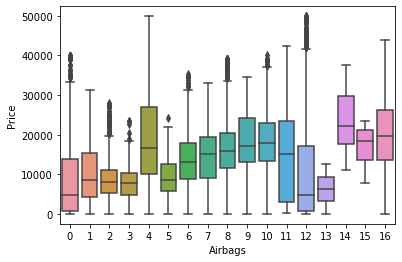

In [23]:
sns.boxplot(x = t_df["Airbags"], y = t_df["Price"])

### AIrbags correction

### Mileage new feature below and it worked

In [24]:
###########################
t_df = df4
milea = []

for mil in df4["Mileage"]:
    if mil==0:
        milea.append(1)
    else:
        milea.append(0)

t_df["New Car"] = milea
t_df.head()

,Price,Prod. year,Leather interior,Cylinders,Airbags,Engine volume,Turbo,Mileage,Model_enc,Color_enc,Manufacturer_enc,Category_enc,Fuel type_enc,Gear box type_enc,Drive wheels_enc,Doors_enc,Wheel_enc,Levy,New Car
0,13328,2010,1,6.0,12,3.5,0,186005,1019.0,12520.5,5018.0,15994.0,9722,11290,9879,12544.0,13172,1399.0,0
1,16621,2011,0,6.0,8,3.0,0,192000,2195.0,11996.0,13150.0,15994.0,11992,17876,9879,12544.0,13172,1018.0,0
2,8467,2006,0,4.0,2,1.3,0,200000,9095.0,11996.0,9408.0,10349.0,11992,13172,13172,12544.0,8467,779.0,0
3,3607,2011,1,4.0,0,2.5,0,168966,2430.5,13485.0,12544.0,15994.0,9722,11290,9879,12544.0,13172,862.0,0
4,11726,2014,1,4.0,4,1.3,0,91901,9095.0,12520.5,9408.0,10349.0,11992,11290,13172,12544.0,13172,446.0,0


In [25]:
###################
df4 = t_df

# CATGEORY AND DOORS MAY BE FIXED

In [26]:
###############################################
#ev_list = []

        #inp=EV_median[(EV_median["Model_enc"]==t_df.loc[i, "Model_enc"]) & (EV_median["Fuel type_enc"]==t_df.loc[i, "Fuel type_enc"])]["Engine volume"].mean()
        #ev_list.append(inp)
    #else:
        #ev_list.append(ev)

#t_df.drop(columns = "Engine volume", inplace = True)
#t_df["Engine volume"] = ev_list

# Feature Importance

In [27]:
from sklearn.ensemble import ExtraTreesRegressor

ETR = ExtraTreesRegressor()
df5 = df4
Y = df5["Price"].astype('float64')
X = df5.drop(columns = "Price", axis = 1)

ETR.fit(X,Y)

ExtraTreesRegressor()

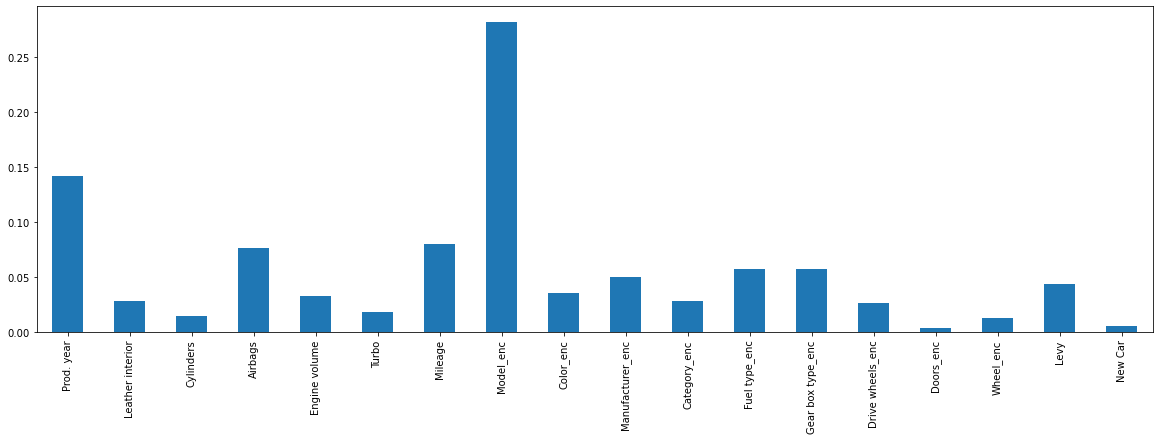

In [28]:
plt.figure(figsize = (20,6))
feat_imp = pd.Series(ETR.feature_importances_, index = X.columns)
feat_imp.plot(kind = 'bar')
plt.show()

<AxesSubplot:>

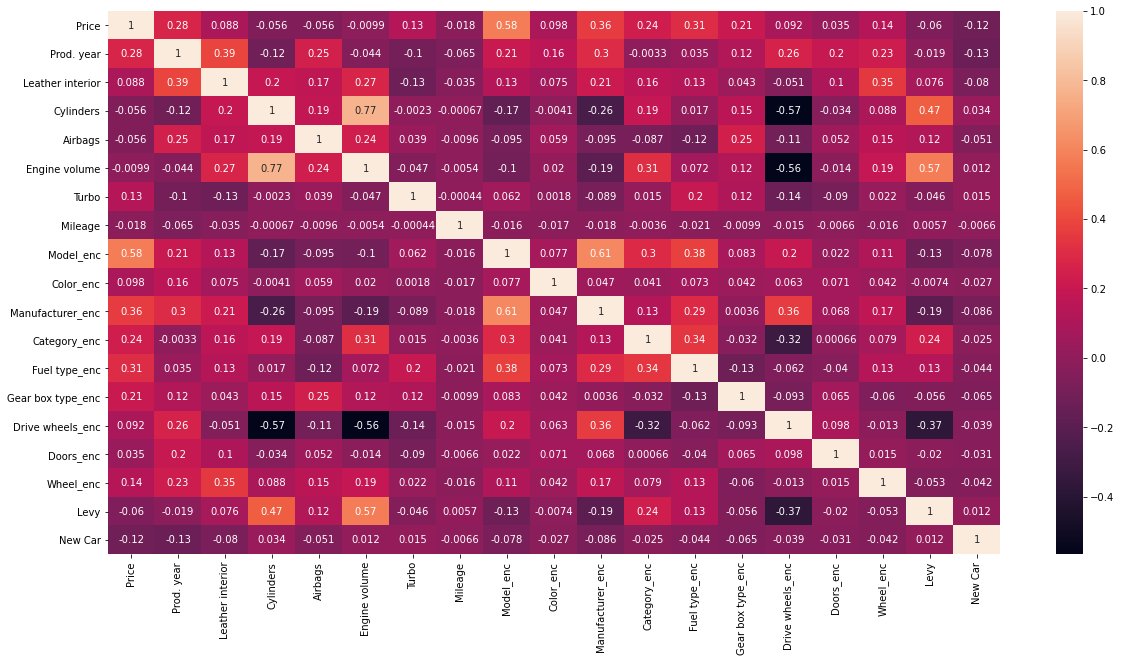

In [29]:
plt.figure(figsize = (20,10))
sns.heatmap(df4.corr(), annot = True)

### Trying to drop Drive Wheels enc

In [30]:
# Trying dropping Mileage and Levy

#df5 = df4.drop(columns = ["Drive wheels_enc"])

######### BAD IDEA #########

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_log_error, r2_score

## Model

In [32]:
model1 = LinearRegression()
#model2 = BayesianRidge()
model3 = RandomForestRegressor()
#model4 = SVR()

In [33]:
from xgboost import XGBRegressor, XGBRFRegressor
model5 = XGBRegressor()
model6 = XGBRFRegressor()

## Scaler

In [57]:
df5 = df4
Y = df5["Price"].astype('float64')
X = df5.drop(columns = "Price", axis = 1)

scaler = MinMaxScaler()
scaler2 = MinMaxScaler()
Y = np.array(Y)
Y = Y.reshape((-1,1))
Y = np.power(Y,0.25)
y = scaler2.fit_transform(Y)

scaler.fit(X)
x = scaler.transform(X)



## Splitting

In [58]:
x_train, x_test, y_train, y_test = train_test_split(x,y, train_size = 0.85, random_state = 7)

In [59]:
model3.fit(x_train, y_train)
y_pred = model3.predict(x_test)
train_pred = model3.predict(x_train)



<ipython-input-59-f30ba591e04d>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model3.fit(x_train, y_train)


In [60]:
############ WIth prod year new feat
y_pred = y_pred.reshape((-1,1))
y_pred = scaler2.inverse_transform(y_pred)
y_pred = np.power(y_pred,4)

train_pred = train_pred.reshape((-1,1))
train_pred = scaler2.inverse_transform(train_pred)
train_pred = np.power(train_pred,4)

y_test = scaler2.inverse_transform(y_test)
y_test = np.power(y_test,4)

y_train = scaler2.inverse_transform(y_train)
y_train = np.power(y_train,4)


test_error = np.sqrt(mean_squared_log_error(y_pred, y_test))
train_error = np.sqrt(mean_squared_log_error(train_pred, y_train))
print("Test R2: ", r2_score(y_pred, y_test))
print("Train R2: ", r2_score(train_pred, y_train))
print("\n")
print("Test set error: ", test_error)
print("Train set error: ", train_error)

Test R2:  0.7120126031932517
Train R2:  0.9412637930879072


Test set error:  0.8958451324236774
Train set error:  0.46454648877817295


In [39]:
############ WIth the new feature
#cbrt and power=0.25 gave good results

df5 = t_df
Y = df5["Price"].astype('float64')
X = df5.drop(columns = "Price", axis = 1)

#############ROBUST
scaler = RobustScaler()
scaler2 = RobustScaler()
Y = np.array(Y)
Y = Y.reshape((-1,1))
Y = np.power(Y,0.25)
#y=Y
y = scaler2.fit_transform(Y)

scaler.fit(X)
x = scaler.transform(X)

x_train, x_test, y_train, y_test = train_test_split(x,y, train_size = 0.75, random_state = 7)

model3.fit(x_train, y_train)
y_pred = model3.predict(x_test)
train_pred = model3.predict(x_train)

y_pred = y_pred.reshape((-1,1))
y_pred = scaler2.inverse_transform(y_pred)
y_pred = np.power(y_pred,4)

train_pred = train_pred.reshape((-1,1))
train_pred = scaler2.inverse_transform(train_pred)
train_pred = np.power(train_pred,4)

y_test = scaler2.inverse_transform(y_test)
y_test = np.power(y_test,4)

y_train = scaler2.inverse_transform(y_train)
y_train = np.power(y_train,4)


test_error = np.sqrt(mean_squared_log_error(y_pred, y_test))
train_error = np.sqrt(mean_squared_log_error(train_pred, y_train))
print("Test R2: ", r2_score(y_pred, y_test))
print("Train R2: ", r2_score(train_pred, y_train))
print("\n")
print("Test set error: ", test_error)
print("Train set error: ", train_error)

<ipython-input-39-c62004abd53d>:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model3.fit(x_train, y_train)


Test R2:  0.6961224879091655
Train R2:  0.9393411685774403


Test set error:  0.908063445579689
Train set error:  0.4674505960860556


In [40]:
X.head()

,Prod. year,Leather interior,Cylinders,Airbags,Engine volume,Turbo,Mileage,Model_enc,Color_enc,Manufacturer_enc,Category_enc,Fuel type_enc,Gear box type_enc,Drive wheels_enc,Doors_enc,Wheel_enc,Levy,New Car
0,2010,1,6.0,12,3.5,0,186005,1019.0,12520.5,5018.0,15994.0,9722,11290,9879,12544.0,13172,1399.0,0
1,2011,0,6.0,8,3.0,0,192000,2195.0,11996.0,13150.0,15994.0,11992,17876,9879,12544.0,13172,1018.0,0
2,2006,0,4.0,2,1.3,0,200000,9095.0,11996.0,9408.0,10349.0,11992,13172,13172,12544.0,8467,779.0,0
3,2011,1,4.0,0,2.5,0,168966,2430.5,13485.0,12544.0,15994.0,9722,11290,9879,12544.0,13172,862.0,0
4,2014,1,4.0,4,1.3,0,91901,9095.0,12520.5,9408.0,10349.0,11992,11290,13172,12544.0,13172,446.0,0


## Trying MinMaxScaler

In [41]:
############ WIth sqrt(Y) using MinMaxScaler

df5 = df4
Y = df5["Price"].astype('float64')
X = df5.drop(columns = "Price", axis = 1)

#############ROBUST
scaler = MinMaxScaler()
scaler2 =MinMaxScaler()
Y = np.array(Y)
Y = Y.reshape((-1,1))
Y = np.power(Y,0.25)
#y=Y
y = scaler2.fit_transform(Y)

scaler.fit(X)
x = scaler.transform(X)

x_train, x_test, y_train, y_test = train_test_split(x,y, train_size = 0.75, random_state = 7)

model3.fit(x_train, y_train)
y_pred = model3.predict(x_test)
train_pred = model3.predict(x_train)

y_pred = y_pred.reshape((-1,1))
y_pred = scaler2.inverse_transform(y_pred)
y_pred = np.power(y_pred,4)

train_pred = train_pred.reshape((-1,1))
train_pred = scaler2.inverse_transform(train_pred)
train_pred = np.power(train_pred,4)

y_test = scaler2.inverse_transform(y_test)
y_test = np.power(y_test,4)

y_train = scaler2.inverse_transform(y_train)
y_train = np.power(y_train,4)


test_error = np.sqrt(mean_squared_log_error(y_pred, y_test))
train_error = np.sqrt(mean_squared_log_error(train_pred, y_train))
print("Test R2: ", r2_score(y_pred, y_test))
print("Train R2: ", r2_score(train_pred, y_train))
print("\n")
print("Test set error: ", test_error)
print("Train set error: ", train_error)

<ipython-input-41-6f1c64c115eb>:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model3.fit(x_train, y_train)


Test R2:  0.6922627367204781
Train R2:  0.940298930982536


Test set error:  0.9122360511340835
Train set error:  0.47559769344722963


# Hyperparameter Tuning

In [42]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


In [112]:
# Hyperparameters
n_estimators = [50]
max_feat = ["sqrt"]
max_depth = [int(x) for x in np.linspace(start=10, stop=50, num=5)]
min_sam_split = [2,10,20,30]
min_sam_leaf = [1,10,20,30]

In [113]:
max_depth.append(None)
max_depth

[10, 20, 30, 40, 50, None]

In [114]:
random_grid = {'n_estimators': n_estimators,
                'max_depth': max_depth,
                'max_features': max_feat,
                'min_samples_split': min_sam_split,
                'min_samples_leaf': min_sam_leaf}

In [153]:
random_rf = RandomizedSearchCV(estimator=model3, param_distributions=random_grid, scoring='neg_mean_squared_log_error', n_iter = 150, cv = 2, verbose=2, random_state=7, n_jobs=1)

In [115]:
grid_rf = GridSearchCV(estimator=model3, param_grid=random_grid, scoring='neg_mean_squared_log_error', cv = 2, verbose=2, n_jobs =1)

In [116]:
df5 = df4
Y = df5["Price"].astype('float64')
X = df5.drop(columns = "Price", axis = 1)

scaler = MinMaxScaler()
scaler2 = MinMaxScaler()
Y = np.array(Y)
Y = Y.reshape((-1,1))
Y = np.power(Y, 0.25)
y = scaler2.fit_transform(Y)

scaler.fit(X)
x = scaler.transform(X)

x_train, x_test, y_train, y_test = train_test_split(x,y, train_size = 0.85, random_state = 7)


In [156]:
#y_train = y_train.reshape((-1,))
#random_rf.fit(x_train,y_train)

Fitting 2 folds for each of 150 candidates, totalling 300 fits
[CV] END max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=250; total time=   1.3s
[CV] END max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=250; total time=   1.2s
[CV] END max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=   0.9s
[CV] END max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=   0.9s
[CV] END max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   1.5s
[CV] END max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   1.5s
[CV] END max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; tota

[CV] END max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=250; total time=   3.9s
[CV] END max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=250; total time=   1.4s
[CV] END max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=250; total time=   1.5s
[CV] END max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=250; total time=   3.9s
[CV] END max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=250; total time=   3.9s
[CV] END max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   1.9s
[CV] END max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   1.9s
[CV] END max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   2.0s
[CV] END max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   2.0s
[CV] END max_features=log2, min_samples_lea

[CV] END max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   2.6s
[CV] END max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   3.5s
[CV] END max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   3.5s
[CV] END max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=300; total time=   4.7s
[CV] END max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=300; total time=   4.7s
[CV] END max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   2.8s
[CV] END max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   2.8s
[CV] END max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=150; total time=   2.6s
[CV] END max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=150; total time=   2.6s
[CV] END max_features=sqrt, min_samples_

[CV] END max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   1.1s
[CV] END max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.9s
[CV] END max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.9s
[CV] END max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=250; total time=   1.6s
[CV] END max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=250; total time=   1.7s
[CV] END max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   5.1s
[CV] END max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   5.1s
[CV] END max_features=sqrt, min_samples_lea

RandomizedSearchCV(cv=2, estimator=RandomForestRegressor(), n_iter=150,
                   n_jobs=1,
                   param_distributions={'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 5],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 150, 200, 250,
                                                         300]},
                   random_state=7, scoring='neg_mean_squared_log_error',
                   verbose=2)

In [117]:
y_train = y_train.reshape((-1,))
grid_rf.fit(x_train,y_train)

Fitting 2 folds for each of 96 candidates, totalling 192 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=50; total time=   0.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=50; total time=   0.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=30, n_estimators=50; total time=   0.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=30, n_estimators=50;

[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=50; total time=   0.4s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=50; total time=   0.3s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=30, n_estimators=50; total time=   0.4s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=30, n_estimators=50; total time=   0.3s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END max_depth=30, max_features=sq

[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=50; total time=   0.3s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=10, min_samples_split=20, n_estimators=50; total time=   0.3s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=50; total time=   0.2s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=50; total time=   0.2s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=20, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=50, max_feature

GridSearchCV(cv=2, estimator=RandomForestRegressor(), n_jobs=1,
             param_grid={'max_depth': [10, 20, 30, 40, 50, None],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [1, 10, 20, 30],
                         'min_samples_split': [2, 10, 20, 30],
                         'n_estimators': [50]},
             scoring='neg_mean_squared_log_error', verbose=2)

In [160]:
#random_rf.best_params_


{'n_estimators': 300,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt'}

In [118]:
grid_rf.best_params_

{'max_depth': 50,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 50}

In [119]:
y_pred = grid_rf.predict(x_test)
train_pred = grid_rf.predict(x_train)

y_pred = y_pred.reshape((-1,1))
y_pred = scaler2.inverse_transform(y_pred)
y_pred = np.power(y_pred,4)

train_pred = train_pred.reshape((-1,1))
train_pred = scaler2.inverse_transform(train_pred)
train_pred = np.power(train_pred,4)


y_test = scaler2.inverse_transform(y_test)
y_test = np.power(y_test,4)

y_train = y_train.reshape((-1,1))
y_train = scaler2.inverse_transform(y_train)
y_train = np.power(y_train,4)


test_error = np.sqrt(mean_squared_log_error(y_pred, y_test))
train_error = np.sqrt(mean_squared_log_error(train_pred, y_train))
print("Test R2: ", r2_score(y_pred, y_test))
print("Train R2: ", r2_score(train_pred, y_train))
print("\n")
print("Test set error: ", test_error)
print("Train set error: ", train_error)


Test R2:  0.7045083175456188
Train R2:  0.9397515195939283


Test set error:  0.8812899044566268
Train set error:  0.46638180421276626


In [68]:
#grid_rf.best_params_

{'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 150}

In [93]:
gmodel = RandomForestRegressor(n_estimators=250, max_features='sqrt', max_depth = None, min_samples_leaf=1, min_samples_split=2)

In [96]:
df5 = df4
Y = df5["Price"].astype('float64')
X = df5.drop(columns = "Price", axis = 1)

scaler = RobustScaler()
scaler2 = RobustScaler()
Y = np.array(Y)
Y = Y.reshape((-1,1))
Y = np.power(Y, 0.25)
y = scaler2.fit_transform(Y)

scaler.fit(X)
x = scaler.transform(X)

x_train, x_test, y_train, y_test = train_test_split(x,y, train_size = 0.85, random_state = 7)

gmodel.fit(x_train, y_train)

y_pred = gmodel.predict(x_test)
train_pred = gmodel.predict(x_train)

y_pred = y_pred.reshape((-1,1))
y_pred = scaler2.inverse_transform(y_pred)
y_pred = np.power(y_pred,4)

train_pred = train_pred.reshape((-1,1))
train_pred = scaler2.inverse_transform(train_pred)
train_pred = np.power(train_pred,4)


y_test = scaler2.inverse_transform(y_test)
y_test = np.power(y_test,4)

y_train = y_train.reshape((-1,1))
y_train = scaler2.inverse_transform(y_train)
y_train = np.power(y_train,4)


test_error = np.sqrt(mean_squared_log_error(y_pred, y_test))
train_error = np.sqrt(mean_squared_log_error(train_pred, y_train))
print("Test R2: ", r2_score(y_pred, y_test))
print("Train R2: ", r2_score(train_pred, y_train))
print("\n")
print("Test set error: ", test_error)
print("Train set error: ", train_error)


<ipython-input-96-4896dae1d80d>:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  gmodel.fit(x_train, y_train)


Test R2:  0.7086219842418676
Train R2:  0.9423849566638027


Test set error:  0.8736966073952289
Train set error:  0.45604339663558513


In [81]:
###################FINAL MODEL

df5 = df4
Y = df5["Price"].astype('float64')
X = df5.drop(columns = "Price", axis = 1)



scaler = RobustScaler()
scaler2 = RobustScaler()
Y = np.array(Y)
Y = Y.reshape((-1,1))
Y = np.power(Y, 0.25)
y = scaler2.fit_transform(Y)

scaler.fit(X)
x = scaler.transform(X)

#x_train, x_test, y_train, y_test = train_test_split(x,y, train_size = 0.75, random_state = 7)


fmodel = RandomForestRegressor(n_estimators=150, max_features='sqrt', max_depth = None, min_samples_leaf=1, min_samples_split=2)

fmodel.fit(x,y)

<ipython-input-81-f4cb63847f39>:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  fmodel.fit(x,y)


RandomForestRegressor(max_features='sqrt', n_estimators=150)

## Reading test set

In [97]:
test = pd.read_csv("test.csv")
test.head()

,ID,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Price
0,44020629,-,VOLKSWAGEN,Golf,2012,Hatchback,No,Diesel,2.0 Turbo,0 km,4,Manual,Front,02-Mar,Left wheel,Grey,10,NaN
1,45784798,-,HYUNDAI,Sonata,2012,Sedan,Yes,Petrol,2.4,26000 km,4,Tiptronic,Front,04-May,Left wheel,Grey,10,NaN
2,45800257,-,NISSAN,Tiida,2005,Sedan,No,Petrol,1.5,168000 km,4,Automatic,Front,04-May,Right-hand drive,Sky blue,8,NaN
3,45797981,975,VOLVO,XC90,2012,Jeep,Yes,Petrol,3.2,143000 km,6,Automatic,4x4,04-May,Left wheel,Blue,12,NaN
4,45814303,-,OPEL,Astra,1993,Hatchback,No,Petrol,1.6,200000 km,4,Manual,Front,04-May,Left wheel,Black,0,NaN


## Preprocessing the test set

### Engine Volume

In [98]:
test = Eng_Vol2(test)
test.head()

,ID,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Price,Engine volume,Turbo
0,44020629,-,VOLKSWAGEN,Golf,2012,Hatchback,No,Diesel,0 km,4,Manual,Front,02-Mar,Left wheel,Grey,10,NaN,2.0,1
1,45784798,-,HYUNDAI,Sonata,2012,Sedan,Yes,Petrol,26000 km,4,Tiptronic,Front,04-May,Left wheel,Grey,10,NaN,2.4,0
2,45800257,-,NISSAN,Tiida,2005,Sedan,No,Petrol,168000 km,4,Automatic,Front,04-May,Right-hand drive,Sky blue,8,NaN,1.5,0
3,45797981,975,VOLVO,XC90,2012,Jeep,Yes,Petrol,143000 km,6,Automatic,4x4,04-May,Left wheel,Blue,12,NaN,3.2,0
4,45814303,-,OPEL,Astra,1993,Hatchback,No,Petrol,200000 km,4,Manual,Front,04-May,Left wheel,Black,0,NaN,1.6,0


### Mileage

In [99]:
mile = []
for mil in test["Mileage"]:
    mil = mil[0:-3]
    mile.append(int(mil))

test.drop(columns = "Mileage", inplace = True)
test["Mileage"] = mile

### ID and Levy

In [100]:
test.drop(columns = "ID", inplace = True)
test["Levy"].replace(to_replace='-', value = np.nan, inplace = True)
test["Levy"] = pd.to_numeric(test["Levy"])
test["Levy"].fillna(Levy_median, inplace = True )

In [414]:
test['Model'].value_counts()

Sonata           478
Prius            448
Camry            390
Elantra          378
E 350            258
                ... 
Allroad            1
Astra bertoni      1
GX 470 470         1
220 W153           1
XJL                1
Name: Model, Length: 995, dtype: int64

### Target Encoding

In [101]:
categ_var = ["Model", "Color", "Manufacturer", "Category", "Fuel type", "Gear box type", "Drive wheels", "Doors", "Wheel"]
t = test
for var in categ_var:
    #encodings = df4.groupby(var)['Price'].median().reset_index()
    t = t.merge(tar_enc_dict[var], how='left', on=var)
    t.drop(var, axis=1, inplace=True)
    t.rename(columns = {"Price_y": var + "_enc", "Price_x": "Price"}, inplace = True) 

### Leather interior and dropping price

In [102]:
#For Leather Interiors
t["Leather interior"].replace({"Yes":1, "No":0}, inplace = True)
t.drop(columns = "Price", inplace = True)
t.dtypes

Levy                 float64
Prod. year             int64
Leather interior       int64
Cylinders              int64
Airbags                int64
Engine volume        float64
Turbo                  int64
Mileage                int64
Model_enc            float64
Color_enc            float64
Manufacturer_enc     float64
Category_enc         float64
Fuel type_enc          int64
Gear box type_enc      int64
Drive wheels_enc       int64
Doors_enc            float64
Wheel_enc              int64
dtype: object

In [417]:
t.isnull().any()

Levy                 False
Prod. year           False
Leather interior     False
Cylinders            False
Airbags              False
Engine volume        False
Turbo                False
Mileage              False
Model_enc             True
Color_enc            False
Manufacturer_enc      True
Category_enc         False
Fuel type_enc        False
Gear box type_enc    False
Drive wheels_enc     False
Doors_enc            False
Wheel_enc            False
dtype: bool

In [103]:
model_med = tar_enc_dict["Model"]["Price"].median()
manufac_med = tar_enc_dict["Manufacturer"]["Price"].median()
t["Model_enc"] = t["Model_enc"].fillna(model_med)
t["Manufacturer_enc"] = t["Manufacturer_enc"].fillna(manufac_med)

In [104]:
################# FIXING LEVY
levy_t = []
for l in t["Levy"]:
    if l>2000:
        levy_t.append(levy_max)
    elif(l<77):
        levy_t.append(levy_min)
    else:
        levy_t.append(l)
        
t.drop(columns = "Levy", inplace = True)
t["Levy"] = levy_t
t.shape

(8245, 17)

In [105]:
########################### ADDING NEW CAR AS A FEATURE
milea = []

for mil in t["Mileage"]:
    if mil==0:
        milea.append(1)
    else:
        milea.append(0)

t["New Car"] = milea
t.shape

(8245, 18)

In [106]:
t.isnull().any()

Prod. year           False
Leather interior     False
Cylinders            False
Airbags              False
Engine volume        False
Turbo                False
Mileage              False
Model_enc            False
Color_enc            False
Manufacturer_enc     False
Category_enc         False
Fuel type_enc        False
Gear box type_enc    False
Drive wheels_enc     False
Doors_enc            False
Wheel_enc            False
Levy                 False
New Car              False
dtype: bool

In [139]:
enc_dict["Model"]["Price"].median()

13485.0

## Scale

In [107]:
x_t = scaler.transform(t)

In [108]:
y_t = fmodel.predict(x_t)

In [109]:
y_p = y_t.reshape((-1,1))
y_p = scaler2.inverse_transform(y_p)
y_p = np.power(y_p,4)
y_p = pd.DataFrame(y_p)

In [110]:
y_p

,0
0,14971.303978
1,6488.694620
2,7276.887524
3,3765.828989
4,4600.694104
...,...
8240,10163.801822
8241,15521.761685
8242,510.371041
8243,36154.816346


In [111]:
y_p.to_csv("submission13.csv", header = ["Price"], index = False)